In [ ]:
!pip install -qq pytorch_lightning

# Импорты

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import urllib.request
from types import SimpleNamespace
from urllib.error import HTTPError

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import seaborn as sns
import tabulate
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision



%matplotlib inline
from IPython.display import HTML, display, set_matplotlib_formats
from PIL import Image
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from torchvision import transforms
from torchvision.datasets import CIFAR100



In [ ]:
DATASET_PATH = os.environ.get("PATH_DATASETS", "data/")
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "saved_models/ConvNets")

# данные одной формы, быстрее инференс
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Предобученные модели
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial5/"
# Названия моделей
pretrained_files = [
    "GoogleNet.ckpt",
    "ResNet.ckpt",
    "ResNetPreAct.ckpt",
    "DenseNet.ckpt",
]
# создадим папки моделей
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# Скачиваем модели, если существуют
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/", 1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print(
                "Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n",
                e,
            )

In [ ]:
# 
train_dataset = CIFAR100(root=DATASET_PATH, train=True, download=True)

DATA_MEANS = (train_dataset.data / 255.0).mean(axis=(0, 1, 2))
DATA_STD = (train_dataset.data / 255.0).std(axis=(0, 1, 2))
print("Data mean", DATA_MEANS)
print("Data std", DATA_STD)

Files already downloaded and verified
Data mean [0.50707516 0.48654887 0.44091784]
Data std [0.26733429 0.25643846 0.27615047]


In [ ]:
test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(DATA_MEANS, DATA_STD)])
# For training, we add some augmentation. Networks are too powerful and would overfit.
train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize(DATA_MEANS, DATA_STD),
    ]
)
# Loading the training dataset. We need to split it into a training and validation part
# We need to do a little trick because the validation set should not use the augmentation.
train_dataset = CIFAR100(root=DATASET_PATH, train=True, transform=train_transform, download=True)
val_dataset = CIFAR100(root=DATASET_PATH, train=True, transform=test_transform, download=True)

train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000])

_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000])

# Loading the test set
test_set = CIFAR100(root=DATASET_PATH, train=False, transform=test_transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
imgs, _ = next(iter(train_loader))
print("Batch mean", imgs.mean(dim=[0, 2, 3]))
print("Batch std", imgs.std(dim=[0, 2, 3]))

Batch mean tensor([-0.0985, -0.1407, -0.1038])
Batch std tensor([0.9167, 0.8991, 0.8913])


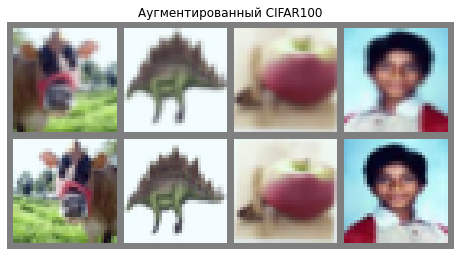

In [ ]:
NUM_IMAGES = 4
images = [train_dataset[idx][0] for idx in range(NUM_IMAGES)]
orig_images = [Image.fromarray(train_dataset.data[idx]) for idx in range(NUM_IMAGES)]
orig_images = [test_transform(img) for img in orig_images]

img_grid = torchvision.utils.make_grid(torch.stack(images + orig_images, dim=0), nrow=4, normalize=True, pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8, 8))
plt.title("Аугментированный CIFAR100")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

В PyTorch Lightning мы определяем pl.LightningModule (наследующий от Module), который организует наш код в 5 основных разделов:

1. Инициализация (`__init__`), где мы создаем все необходимые параметры/модели

2. Оптимизаторы (`configure_optimizers`), где мы создаем оптимизаторы, планировщик скорости обучения и т.д.

3. Цикл обучения (`training_step`), где нам нужно определить вычисление потерь только для одного пакета (цикл `optimizer.zero_grad()`, `loss.backward()` и `optimizer.step()`, а также любая операция протоколирования / сохранения выполняются в фоновом режиме)

4. Цикл проверки (`validation_step`), где, аналогично обучению, нам нужно только определить, что должно происходить на каждом шаге

5. Тестовый цикл (`test_step`), который совпадает с проверкой, только на тестовом наборе.

In [ ]:
class CIFARModule(pl.LightningModule):
    def __init__(self, model_name, model_hparams, optimizer_name, optimizer_hparams):
        """
        Inputs:
            model_name - Name of the model/CNN to run. Used for creating the model (see function below)
            model_hparams - Hyperparameters for the model, as dictionary.
            optimizer_name - Name of the optimizer to use. Currently supported: Adam, SGD
            optimizer_hparams - Hyperparameters for the optimizer, as dictionary. This includes learning rate, weight decay, etc.
        """
        super().__init__()
        # Exports the hyperparameters to a YAML file, and create "self.hparams" namespace
        self.save_hyperparameters()
        # Create model
        self.model = create_model(model_name, model_hparams)
        # Create loss module
        self.loss_module = nn.CrossEntropyLoss()
        # Example input for visualizing the graph in Tensorboard
        self.example_input_array = torch.zeros((1, 3, 32, 32), dtype=torch.float32)

    def forward(self, imgs):
        # Forward function that is run when visualizing the graph
        return self.model(imgs)

    def configure_optimizers(self):
        # We will support Adam or SGD as optimizers.
        if self.hparams.optimizer_name == "Adam":
            # AdamW is Adam with a correct implementation of weight decay (see here
            # for details: https://arxiv.org/pdf/1711.05101.pdf)
            optimizer = optim.AdamW(self.parameters(), **self.hparams.optimizer_hparams)
        elif self.hparams.optimizer_name == "SGD":
            optimizer = optim.SGD(self.parameters(), **self.hparams.optimizer_hparams)
        else:
            assert False, f'Unknown optimizer: "{self.hparams.optimizer_name}"'

        # We will reduce the learning rate by 0.1 after 100 and 150 epochs
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        # "batch" is the output of the training data loader.
        imgs, labels = batch
        preds = self.model(imgs)
        loss = self.loss_module(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        # Logs the accuracy per epoch to tensorboard (weighted average over batches)
        self.log("train_acc", acc, on_step=False, on_epoch=True)
        self.log("train_loss", loss)
        return loss  # Return tensor to call ".backward" on

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        # By default logs it per epoch (weighted average over batches)
        self.log("val_acc", acc)

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        # By default logs it per epoch (weighted average over batches), and returns it afterwards
        self.log("test_acc", acc)

Другой важной частью PyTorch Lightning является концепция колбеков (callbacks, / обратный вызовов). Колбеки - это автономные функции, которые содержат несущественную логику вашего модуля Lightning. 

Обычно они вызываются после завершения периода обучения, но также могут влиять на другие части вашего цикла обучения. Например, мы будем использовать следующие два предопределенных обратных вызова: LearningRateMonitor и ModelCheckpoint. 

Монитор скорости обучения добавляет текущую скорость обучения в нашу TensorBoard, что помогает убедиться, что наш планировщик скорости обучения работает правильно. 

Обратный вызов контрольной точки модели позволяет вам настроить процедуру сохранения ваших контрольных точек. 

Например, сколько контрольных точек сохранить, когда сохранить, на какую метрику обратить внимание и т.д. Мы импортируем их ниже:

In [ ]:
model_dict = {}

def create_model(model_name, model_hparams):
    if model_name in model_dict:
        return model_dict[model_name](**model_hparams)
    else:
        assert False, f'Unknown model name "{model_name}". Available models are: {str(model_dict.keys())}'

In [ ]:
act_fn_by_name = {"tanh": nn.Tanh, "relu": nn.ReLU, "leakyrelu": nn.LeakyReLU, "gelu": nn.GELU}

Помимо модуля Lightning, вторым по важности модулем в PyTorch Lightning является Trainer. Тренер отвечает за выполнение шагов обучения, определенных в модуле Lightning, и завершает фреймворк. Подобно модулю Lightning, вы можете переопределить любую ключевую часть, которую вы не хотите автоматизировать, но часто лучше всего использовать настройки по умолчанию. Полный обзор см. в документации. Наиболее важными функциями, которые мы используем ниже, являются:

* `trainer.fit`: принимает в качестве входных данных модуль lightning, обучающий набор данных и (необязательно) проверочный набор данных. Эта функция обучает данный модуль на обучающем наборе данных с периодической проверкой (по умолчанию один раз в эпоху, может быть изменена)

* `trainer.test`: принимает в качестве входных данных модель и набор данных, на которых мы хотим протестировать. Он возвращает тестовую метрику в наборе данных.

Для обучения и тестирования нам не нужно беспокоиться о таких вещах, как перевод модели в режим оценки (model.eval()), поскольку все это делается автоматически. Смотрите ниже, как мы определяем обучающую функцию для наших моделей:

In [ ]:
def train_model(model_name, save_name=None, **kwargs):
    """
    Inputs:
        model_name - Name of the model you want to run. Is used to look up the class in "model_dict"
        save_name (optional) - If specified, this name will be used for creating the checkpoint and logging directory.
    """
    if save_name is None:
        save_name = model_name

    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, save_name),  # Where to save models
        # We run on a single GPU (if possible)
        gpus=1 if str(device) == "cuda:0" else 0,
        # How many epochs to train for if no patience is set
        max_epochs=180,
        callbacks=[
            ModelCheckpoint(
                save_weights_only=True, mode="max", monitor="val_acc"
            ),  # Save the best checkpoint based on the maximum val_acc recorded. Saves only weights and not optimizer
            LearningRateMonitor("epoch"),
        ],  # Log learning rate every epoch
    )  # In case your notebook crashes due to the progress bar, consider increasing the refresh rate
    trainer.logger._log_graph = True  # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None  # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, save_name + ".ckpt")


    model = CIFARModule(model_name=model_name, **kwargs)

    trainer.fit(model, train_loader, val_loader)
    model = CIFARModule.load_from_checkpoint(
        trainer.checkpoint_callback.best_model_path
    )  # Load best checkpoint after training

    # Test best model on validation and test set
    val_result = trainer.test(model, dataloaders=val_loader, verbose=False)
    test_result = trainer.test(model, dataloaders=test_loader, verbose=False)
    result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}

    return model, result

## Inception

GoogLeNet, предложенный в 2014 году, выиграл конкурс ImageNet Challenge благодаря использованию модулей начального уровня. В целом, в этом руководстве мы в основном сосредоточимся на концепции Inception, а не на особенностях GoogLeNet, поскольку на основе Inception было создано множество последующих работ (Inception-v2, Inception-v3, Inception-v4, Inception-ResNet,...). Последующие работы в основном сосредоточены на повышении эффективности и создании очень глубоких первоначальных сетей. Однако для фундаментального понимания достаточно взглянуть на исходный начальный блок.

Начальный блок применяет четыре блока свертки отдельно к одной и той же карте объектов: свертка 1x1, 3x3 и 5x5 и операция максимального пула. Это позволяет сети просматривать одни и те же данные с разными полями восприятия. Конечно, изучение только свертки 5x5 было бы теоретически более эффективным. Однако это не только увеличивает объем вычислений и памяти, но и, как правило, значительно облегчает перенастройку. Общий начальный блок выглядит следующим образом (рисунок предоставлен - Сегеди и др.):

![](https://github.com/PyTorchLightning/lightning-tutorials/raw/main/course_UvA-DL/04-inception-resnet-densenet/inception_block.svg)

Дополнительные свертки 1x1 перед свертками 3x3 и 5x5 используются для уменьшения размерности. Это особенно важно, поскольку карты объектов всех ветвей впоследствии объединяются, и мы не хотим резкого увеличения размера объектов. Поскольку свертки 5x5 в 25 раз дороже, чем свертки 1x1, мы можем сэкономить много вычислений и параметров, уменьшив размерность перед большими свертками.

Теперь мы можем попытаться реализовать начальный блок самостоятельно:

In [ ]:
class InceptionBlock(nn.Module):
    def __init__(self, c_in, c_red: dict, c_out: dict, act_fn):
        """
        Inputs:
            c_in - Number of input feature maps from the previous layers
            c_red - Dictionary with keys "3x3" and "5x5" specifying the output of the dimensionality reducing 1x1 convolutions
            c_out - Dictionary with keys "1x1", "3x3", "5x5", and "max"
            act_fn - Activation class constructor (e.g. nn.ReLU)
        """
        super().__init__()

        # 1x1 convolution branch
        self.conv_1x1 = nn.Sequential(
            nn.Conv2d(c_in, c_out["1x1"], kernel_size=1),
            nn.BatchNorm2d(c_out["1x1"]),
            act_fn()
        )

        # 3x3 convolution branch
        self.conv_3x3 = nn.Sequential(
            nn.Conv2d(c_in, c_red["3x3"], kernel_size=1),
            nn.BatchNorm2d(c_red["3x3"]),
            act_fn(),
            nn.Conv2d(c_red["3x3"], c_out["3x3"], kernel_size=3, padding=1),
            nn.BatchNorm2d(c_out["3x3"]),
            act_fn(),
        )

        # 5x5 convolution branch
        self.conv_5x5 = nn.Sequential(
            nn.Conv2d(c_in, c_red["5x5"], kernel_size=1),
            nn.BatchNorm2d(c_red["5x5"]),
            act_fn(),
            nn.Conv2d(c_red["5x5"], c_out["5x5"], kernel_size=5, padding=2),
            nn.BatchNorm2d(c_out["5x5"]),
            act_fn(),
        )

        # Max-pool branch
        self.max_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
            nn.Conv2d(c_in, c_out["max"], kernel_size=1),
            nn.BatchNorm2d(c_out["max"]),
            act_fn(),
        )

    def forward(self, x):
        x_1x1 = self.conv_1x1(x)
        x_3x3 = self.conv_3x3(x)
        x_5x5 = self.conv_5x5(x)
        x_max = self.max_pool(x)
        x_out = torch.cat([x_1x1, x_3x3, x_5x5, x_max], dim=1)
        return x_out

Архитектура Google Net состоит из укладки нескольких начальных блоков с периодическим максимальным объединением для уменьшения высоты и ширины карт объектов. Оригинальный GoogLeNet был разработан для размеров изображений ImageNet (224x224 пикселя) и имел почти 7 миллионов параметров. Поскольку мы тренируемся на CIFAR10 с размерами изображений 32x32, нам не требуется такая тяжелая архитектура, и вместо этого мы применяем уменьшенную версию. Количество каналов для уменьшения размерности и выходной мощности на фильтр (1x1, 3x3, 5x5 и максимальное объединение) необходимо указывать вручную и при желании может быть изменено. Общая интуиция заключается в том, чтобы иметь наибольшее количество фильтров для свертки 3x3, поскольку они достаточно мощные, чтобы учитывать контекст, требуя при этом почти трети параметров свертки 5x5.

In [ ]:
class GoogleNet(nn.Module):
    def __init__(self, num_classes=100, act_fn_name="relu", **kwargs):
        super().__init__()
        self.hparams = SimpleNamespace(
            num_classes=num_classes, act_fn_name=act_fn_name, act_fn=act_fn_by_name[act_fn_name]
        )
        self._create_network()
        self._init_params()

    def _create_network(self):
        # A first convolution on the original image to scale up the channel size
        self.input_net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            self.hparams.act_fn()
        )
        # Stacking inception blocks
        self.inception_blocks = nn.Sequential(
            InceptionBlock(
                64,
                c_red={"3x3": 32, "5x5": 16},
                c_out={"1x1": 16, "3x3": 32, "5x5": 8, "max": 8},
                act_fn=self.hparams.act_fn,
            ),
            InceptionBlock(
                64,
                c_red={"3x3": 32, "5x5": 16},
                c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12},
                act_fn=self.hparams.act_fn,
            ),
            nn.MaxPool2d(3, stride=2, padding=1),  # 32x32 => 16x16
            InceptionBlock(
                96,
                c_red={"3x3": 32, "5x5": 16},
                c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12},
                act_fn=self.hparams.act_fn,
            ),
            InceptionBlock(
                96,
                c_red={"3x3": 32, "5x5": 16},
                c_out={"1x1": 16, "3x3": 48, "5x5": 16, "max": 16},
                act_fn=self.hparams.act_fn,
            ),
            InceptionBlock(
                96,
                c_red={"3x3": 32, "5x5": 16},
                c_out={"1x1": 16, "3x3": 48, "5x5": 16, "max": 16},
                act_fn=self.hparams.act_fn,
            ),
            InceptionBlock(
                96,
                c_red={"3x3": 32, "5x5": 16},
                c_out={"1x1": 32, "3x3": 48, "5x5": 24, "max": 24},
                act_fn=self.hparams.act_fn,
            ),
            nn.MaxPool2d(3, stride=2, padding=1),  # 16x16 => 8x8
            InceptionBlock(
                128,
                c_red={"3x3": 48, "5x5": 16},
                c_out={"1x1": 32, "3x3": 64, "5x5": 16, "max": 16},
                act_fn=self.hparams.act_fn,
            ),
            InceptionBlock(
                128,
                c_red={"3x3": 48, "5x5": 16},
                c_out={"1x1": 32, "3x3": 64, "5x5": 16, "max": 16},
                act_fn=self.hparams.act_fn,
            ),
        )

        # Mapping to classification output
        self.output_net = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, self.hparams.num_classes)
        )

    def _init_params(self):
        # Based on our discussion in Tutorial 4, we should initialize the
        # convolutions according to the activation function
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity=self.hparams.act_fn_name)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.input_net(x)
        x = self.inception_blocks(x)
        x = self.output_net(x)
        return x

Теперь мы можем интегрировать нашу модель в словарь моделей, который мы определили выше:

In [ ]:
model_dict["GoogleNet"] = GoogleNet

Обучением модели занимается Pytorch Lightning, и нам просто нужно определить команду для запуска. Обратите внимание, что мы тренируемся почти 200 эпох, что занимает около часа на GTX1080Ti. Лучше использовать сохраненные модели и обучить собственную модель.

In [ ]:
googlenet_model, googlenet_results = train_model(
    model_name="GoogleNet",
    model_hparams={"num_classes": 100, "act_fn_name": "relu"},
    optimizer_name="Adam",
    optimizer_hparams={"lr": 1e-3, "weight_decay": 1e-4},
)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/setup.py:178: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  category=PossibleUserWarning,


AAAAAAAAAAA 100


INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type             | Params | In sizes       | Out sizes
------------------------------------------------------------------------------
0 | model       | GoogleNet        | 272 K  | [1, 3, 32, 32] | [1, 100] 
1 | loss_module | CrossEntropyLoss | 0      | ?              | ?        
------------------------------------------------------------------------------
272 K     Trainable params
0         Non-trainable params
272 K     Total params
1.089     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
print("GoogleNet Results", googlenet_results)

## ResNet

Статья ResNet является одной из наиболее цитируемых работ по искусственному интеллекту и легла в основу нейронных сетей с более чем 1000 слоями. Несмотря на свою простоту, идея остаточных соединений очень эффективна, поскольку она поддерживает стабильное распространение градиента по сети. Вместо моделирования $x_ {l+ 1} = F (x_ {l})$ мы моделируем $x_ {l+ 1}= x_ {l} + F (x_ {l})$, где $F$ - нелинейное отображение (обычно последовательность NN модулей, таких как свертки, функции активации, и нормализации). Если мы сделаем обратное распространение по таким остаточным соединениям, мы получим:

$$\frac{∂ x_{l+1}}{∂ x_l} = I + \frac{∂ F(x_l)}{∂ x_l}$$

Смещение в сторону единичной матрицы гарантирует стабильное распространение градиента, на которое сам F оказывает меньшее влияние. Было предложено много вариантов ResNet, которые в основном касаются функции F или операций, применяемых к сумме. В этом руководстве мы рассмотрим два из них: исходный блок ResNet и блок ResNet предварительной активации. Мы визуально сравниваем блоки ниже (рисунок предоставлен - Он и др.):

![](https://github.com/PyTorchLightning/lightning-tutorials/raw/main/course_UvA-DL/04-inception-resnet-densenet/resnet_block.svg)

Исходный блок ResNet применяет функцию нелинейной активации, обычно ReLU, после пропуска соединения. Напротив, блок предварительной активации ResNet применяет нелинейность в начале $F$. Оба имеют свои преимущества и недостатки. Однако для очень глубокой сети предварительная активация ResNet показала лучшую производительность, поскольку поток градиента гарантированно имеет единичную матрицу, рассчитанную выше, и не страдает от какой-либо нелинейной активации, примененной к нему. Для сравнения, в этом ноутбуке мы реализуем оба типа ResNet как неглубокие сети.

Начнем с исходного блока ResNet. Приведенная выше визуализация уже показывает, какие слои включены в $F$. Один особый случай, с которым нам приходится иметь дело, - это когда мы хотим уменьшить размеры изображения с точки зрения ширины и высоты. Базовый блок ResNet требует, чтобы $F(x_{l})$ имел ту же форму, что и $x_{l}$. Таким образом, нам также нужно изменить размерность $x_ {l}$, прежде чем добавлять к $F (x_{l})$. Первоначальная реализация использовала сопоставление идентификаторов с шагом 2 и добавляла дополнительные размеры объектов с 0. Однако более распространенной реализацией является использование свертки 1x1 с шагом 2, поскольку это позволяет нам изменять размерность объекта, сохраняя при этом эффективность параметров и вычислительных затрат. Код для блока ResNet относительно прост и показан ниже:

In [ ]:
class ResNetBlock(nn.Module):
    def __init__(self, c_in, act_fn, subsample=False, c_out=-1):
        """
        Inputs:
            c_in - количество входных признако
            act_fn - констуркутор активации (напр. nn.ReLU)
            subsample - если True,применяем stride внутри блока и уменьшаем форму на 2 по высоте и ширине
            c_out - количество признаков на выход, релевантно, если subsample is True, иначе, c_out = c_in
        """
        super().__init__()
        if not subsample:
            c_out = c_in

        # блок F
        self.net = nn.Sequential(
            nn.Conv2d(
                c_in, c_out, kernel_size=3, padding=1, stride=1 if not subsample else 2, bias=False
            ),  # без смещения, он в батчнорме
            nn.BatchNorm2d(c_out),
            act_fn(),
            nn.Conv2d(c_out, c_out, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(c_out),
        )

        # 1x1 свертка со stride 2 для преобразования в output size
        self.downsample = nn.Conv2d(c_in, c_out, kernel_size=1, stride=2) if subsample else None
        self.act_fn = act_fn()

    def forward(self, x):
        z = self.net(x)
        if self.downsample is not None:
            x = self.downsample(x)
        out = z + x
        out = self.act_fn(out)
        return out

Второй блок, который мы реализуем, - это блок предварительной активации ResNet. Для этого мы должны изменить порядок слоев в self.net , и не применяйте функцию активации к выходу. Кроме того, операция понижающей дискретизации должна применять нелинейность, а также входные данные, x_l, еще не были обработаны нелинейностью. Следовательно, блок выглядит следующим образом:

In [ ]:
class PreActResNetBlock(nn.Module):
    def __init__(self, c_in, act_fn, subsample=False, c_out=-1):
        """
        Inputs:
            c_in - Количество признаков на вход 
            act_fn - Конструктор класса активации (напр. nn.ReLU)
            subsample - если True,применяем stride внутри блока и уменьшаем форму на 2 по высоте и ширине
            c_out - количество признаков на выход, релевантно, если subsample is True, иначе, c_out = c_in
        """
        super().__init__()
        if not subsample:
            c_out = c_in

        # Network representing F
        self.net = nn.Sequential(
            nn.BatchNorm2d(c_in),
            act_fn(),
            nn.Conv2d(c_in, c_out, kernel_size=3, padding=1, stride=1 if not subsample else 2, bias=False),
            nn.BatchNorm2d(c_out),
            act_fn(),
            nn.Conv2d(c_out, c_out, kernel_size=3, padding=1, bias=False),
        )

        # 1x1 convolution needs to apply non-linearity as well as not done on skip connection
        self.downsample = (
            nn.Sequential(nn.BatchNorm2d(c_in),
                          act_fn(),
                          nn.Conv2d(c_in, c_out, kernel_size=1, stride=2, bias=False))
            if subsample
            else None
        )

    def forward(self, x):
        z = self.net(x)
        if self.downsample is not None:
            x = self.downsample(x)
        out = z + x
        return out

Аналогично выбору модели, мы определяем словарь для создания сопоставления из string в block class. Мы будем использовать имя строки в качестве значения гиперпараметра в нашей модели для выбора между блоками ResNet. Не стесняйтесь внедрять любой другой тип блока ResNet и добавлять его также сюда.

In [ ]:
resnet_blocks_by_name = {"ResNetBlock": ResNetBlock, "PreActResNetBlock": PreActResNetBlock}

Общая архитектура ResNet состоит из нескольких блоков ResNet, некоторые из которых уменьшают дискретизацию входных данных. Когда мы говорим о блоках ResNet во всей сети, мы обычно группируем их по одной и той же форме вывода. Следовательно, если мы говорим, что ResNet имеет блоки [3,3,3], это означает, что у нас 3 раза группа из 3 блоков ResNet, где подвыборка происходит в четвертом и седьмом блоке. Сеть ResNet с блоками [3,3,3] на CIFAR10 визуализирована ниже.

![](https://github.com/PyTorchLightning/lightning-tutorials/raw/main/course_UvA-DL/04-inception-resnet-densenet/resnet_notation.svg)

Три группы работают с разрешениями 32 на 32, 16 на 16 и 8 на 8 соответственно. Блоки оранжевого цвета обозначают блоки ResNet с понижающей размерностью. Те же обозначения используются во многих других реализациях, например, в библиотеке torch vision от Pytorch. Таким образом, наш код выглядит следующим образом:

In [ ]:
class ResNet(nn.Module):
    def __init__(
        self,
        num_classes=100,
        num_blocks=[3, 3, 3],
        c_hidden=[16, 32, 64],
        act_fn_name="relu",
        block_name="ResNetBlock",
        **kwargs,
    ):
        """
        Inputs:
            num_classes - кол-во классов (100 for CIFAR100)
            num_blocks - Кол-во блоков Resnet
            c_hidden - список скрытых размеров разных блоков
            act_fn_name - название ф-ии активации
            block_name - название блока ResNet
        """
        super().__init__()
        assert block_name in resnet_blocks_by_name
        self.hparams = SimpleNamespace(
            num_classes=num_classes,
            c_hidden=c_hidden,
            num_blocks=num_blocks,
            act_fn_name=act_fn_name,
            act_fn=act_fn_by_name[act_fn_name],
            block_class=resnet_blocks_by_name[block_name],
        )
        self._create_network()
        self._init_params()

    def _create_network(self):
        c_hidden = self.hparams.c_hidden

        # Первая свертка исходного изображения для увеличения размера канала
        if self.hparams.block_class == PreActResNetBlock:  #=> Не применяйте нелинейность к выходным данным
            self.input_net = nn.Sequential(nn.Conv2d(3, c_hidden[0], kernel_size=3, padding=1, bias=False))
        else:
            self.input_net = nn.Sequential(
                nn.Conv2d(3, c_hidden[0], kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(c_hidden[0]),
                self.hparams.act_fn(),
            )

        # создаем блоки ResNet
        blocks = []
        for block_idx, block_count in enumerate(self.hparams.num_blocks):
            for bc in range(block_count):
                # Подвыборка первого блока каждой группы, кроме самого первого
                subsample = bc == 0 and block_idx > 0
                blocks.append(
                    self.hparams.block_class(
                        c_in=c_hidden[block_idx if not subsample else (block_idx - 1)],
                        act_fn=self.hparams.act_fn,
                        subsample=subsample,
                        c_out=c_hidden[block_idx],
                    )
                )
        self.blocks = nn.Sequential(*blocks)

        # отображение на классификацию
        self.output_net = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(c_hidden[-1], self.hparams.num_classes)
        )

    def _init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity=self.hparams.act_fn_name)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.input_net(x)
        x = self.blocks(x)
        x = self.output_net(x)
        return x

Нам также нужно добавить новый класс ResNet в наш словарь моделей:

In [ ]:
model_dict["ResNet"] = ResNet

Наконец, posthume может обучать наши модели ResNet. Одно из отличий от обучения в GoogLeNet заключается в том, что она специально использует SGD Tiffith Momentum в качестве оптимизатора вместо Adam. Adam предлагает несколько более высокую точность при обычном сбросе, чем при обычном сбросе. Это не на 100% ясно, но одно из возможных объяснений связано с поверхностью потерь Restnet. ResNet был оптимизирован для получения более плавных поверхностей потерь, чем подключение netmaximor без подключения к сети (подробности см. Li et al. 2018). Возможная визуализация поверхности потерь жертв жертв (рисунок предоставлен Ли и др.). ):

![](https://github.com/PyTorchLightning/lightning-tutorials/raw/main/course_UvA-DL/04-inception-resnet-densenet/resnet_loss_surface.png)

Оси x и y показывают проекцию пространства параметров, а ось z показывает значения потерь, достигнутые при различных значениях параметров. На гладких поверхностях, подобных той, что справа, нам может не потребоваться адаптивная скорость обучения, которую обеспечивает Adam. Вместо этого Adam может застрять в локальных оптимумах, в то время как SGD находит более широкие минимумы, которые, как правило, лучше обобщаются. Однако, чтобы подробно ответить на этот вопрос, нам понадобится дополнительное руководство, потому что ответить на него непросто. На данный момент мы делаем вывод: для архитектур ResNet рассматривайте оптимизатор как важный гиперпараметр и попробуйте тренироваться как с Adam, так и с SGD. Давайте обучим приведенную ниже модель с помощью SGD:

In [ ]:
resnet_model, resnet_results = train_model(
    model_name="ResNet",
    model_hparams={"num_classes": 100, "c_hidden": [16, 32, 64], "num_blocks": [3, 3, 3], "act_fn_name": "relu"},
    optimizer_name="SGD",
    optimizer_hparams={"lr": 0.1, "momentum": 0.9, "weight_decay": 1e-4},
)

In [ ]:
resnetpreact_model, resnetpreact_results = train_model(
    model_name="ResNet",
    model_hparams={
        "num_classes": 100,
        "c_hidden": [16, 32, 64],
        "num_blocks": [3, 3, 3],
        "act_fn_name": "relu",
        "block_name": "PreActResNetBlock",
    },
    optimizer_name="SGD",
    optimizer_hparams={"lr": 0.1, "momentum": 0.9, "weight_decay": 1e-4},
    save_name="ResNetPreAct",
)

## DenseNet

Плотная архитектура Nicht is gemeinde предназначена для создания очень глубоких нейронных сетей и имеет несколько иной взгляд на остаточные соединения. Вместо моделирования различий между слоями, Dense Nicht рассматривает остаточные соединения как возможный способ повторного использования объектов на разных уровнях, устраняя необходимость в изучении избыточных карт объектов. Если мы углубимся в сеть, модель научится распознавать абстрактные объекты для распознавания шаблонов. Однако некоторые сложные узоры состоят из комбинации абстрактных элементов (например, руки, лица и т. Д. ) И низкоуровневых элементов (например, краев, базового цвета и т. Д.). Некоторые сложные узоры состоят из комбинации абстрактных элементов (например, руки, лица и т. Д. ) И низкоуровневых элементов (например, краев, основного цвета и т. Д.). Чтобы найти эти низкоуровневые объекты в глубоких слоях, стандартные CNN должны научиться копировать такие карты объектов, что приводит к большой сложности параметров. Dense Nicht обеспечивает эффективный способ сокращения функций, поскольку каждая свертка зависит от всех предыдущих входных функций, но к ней добавляется только небольшое количество фильтров. Иллюстрацию см. В разделе "Несущий" ниже (рисунки credit - Haben и др. ).:

![](https://github.com/PyTorchLightning/lightning-tutorials/raw/main/course_UvA-DL/04-inception-resnet-densenet/densenet_block.svg)

Последний слой, называемый переходным слоем, отвечает за уменьшение размерности карт объектов по высоте, ширине и размеру канала. Хотя технически они нарушают обратное распространение идентификаторов, в сети их всего несколько, так что это не сильно влияет на градиентный поток.

Мы разделили реализацию слоев в Dense Net на три части: плотный слой, плотный блок и переходный слой. Модуль Плотный слой реализует один слой внутри плотного блока. Он применяет свертку 1x1 для уменьшения размерности с последующей сверткой 3x3. Выходные каналы объединяются с оригиналами и возвращаются. Обратите внимание, что мы применяем пакетную нормализацию в качестве первого слоя каждого блока. Это позволяет немного по-разному активировать одни и те же функции на разных слоях, в зависимости от того, что необходимо. В целом, мы можем реализовать это следующим образом:

In [ ]:
class DenseLayer(nn.Module):
    def __init__(self, c_in, bn_size, growth_rate, act_fn):
        """
        Inputs:
            c_in - кол-во входных каналов
            bn_size - размер ботлнека
            growth_rate - количество выходных канало свертки 3x3
            act_fn - конструктор активации (nn.ReLU)
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.BatchNorm2d(c_in),
            act_fn(),
            nn.Conv2d(c_in, bn_size * growth_rate, kernel_size=1, bias=False),
            nn.BatchNorm2d(bn_size * growth_rate),
            act_fn(),
            nn.Conv2d(bn_size * growth_rate, growth_rate, kernel_size=3, padding=1, bias=False),
        )

    def forward(self, x):
        out = self.net(x)
        out = torch.cat([out, x], dim=1)
        return out

Модульный плотный блок суммирует несколько плотных слоев, нанесенных последовательно. Каждый плотный слой принимает в качестве входных данных исходные входные данные, объединенные с картами объектов всех предыдущих слоев:

In [ ]:
class DenseBlock(nn.Module):
    def __init__(self, c_in, num_layers, bn_size, growth_rate, act_fn):
        """
        Inputs:
            c_in - кол-во входных каналов
            num_layers - кол-во слоев
            bn_size - размер ботлнека
            growth_rate - количество выходных канало свертки 3x3
            act_fn - конструктор активации (nn.ReLU)
        """
        super().__init__()
        layers = []
        for layer_idx in range(num_layers):
            # Input channels are original plus the feature maps from previous layers
            layer_c_in = c_in + layer_idx * growth_rate
            layers.append(DenseLayer(c_in=layer_c_in, bn_size=bn_size, growth_rate=growth_rate, act_fn=act_fn))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        out = self.block(x)
        return out

Наконец, переходный слой принимает в качестве входных данных конечный результат плотного блока и уменьшает размерность его канала, используя свертку 1x1. Чтобы уменьшить размеры по высоте и ширине, мы используем несколько иной подход, чем в ResNet, и применяем среднее объединение с размером ядра 2 и шагом 2. Это связано с тем, что у нас нет дополнительного подключения к выходу, которое учитывало бы полный патч 2x2 вместо одного значения. Кроме того, это более эффективно с точки зрения параметров, чем использование свертки 3x3 с шагом 2. Таким образом, слой реализован следующим образом:

In [ ]:
class TransitionLayer(nn.Module):
    def __init__(self, c_in, c_out, act_fn):
        super().__init__()
        self.transition = nn.Sequential(
            nn.BatchNorm2d(c_in),
            act_fn(),
            nn.Conv2d(c_in, c_out, kernel_size=1, bias=False),
            nn.AvgPool2d(kernel_size=2, stride=2),  # Average the output for each 2x2 pixel group
        )

    def forward(self, x):
        return self.transition(x)

Теперь мы можем собрать все воедино и создать нашу плотную сеть. Чтобы указать количество слоев, мы используем обозначения, аналогичные тем, что используются в ResNets, и передаем список целых чисел, представляющих количество слоев в блоке. После каждого плотного блока, кроме последнего, мы наносим переходный слой, чтобы уменьшить размерность на 2.

In [ ]:
class DenseNet(nn.Module):
    def __init__(
        self, num_classes=10, num_layers=[6, 6, 6, 6], bn_size=2, growth_rate=16, act_fn_name="relu", **kwargs
    ):
        super().__init__()
        self.hparams = SimpleNamespace(
            num_classes=num_classes,
            num_layers=num_layers,
            bn_size=bn_size,
            growth_rate=growth_rate,
            act_fn_name=act_fn_name,
            act_fn=act_fn_by_name[act_fn_name],
        )
        self._create_network()
        self._init_params()

    def _create_network(self):
        c_hidden = self.hparams.growth_rate * self.hparams.bn_size  # The start number of hidden channels

        # A first convolution on the original image to scale up the channel size
        self.input_net = nn.Sequential(
            # No batch norm or activation function as done inside the Dense layers
            nn.Conv2d(3, c_hidden, kernel_size=3, padding=1)
        )

        # Creating the dense blocks, eventually including transition layers
        blocks = []
        for block_idx, num_layers in enumerate(self.hparams.num_layers):
            blocks.append(
                DenseBlock(
                    c_in=c_hidden,
                    num_layers=num_layers,
                    bn_size=self.hparams.bn_size,
                    growth_rate=self.hparams.growth_rate,
                    act_fn=self.hparams.act_fn,
                )
            )
            c_hidden = c_hidden + num_layers * self.hparams.growth_rate  # Overall output of the dense block
            if block_idx < len(self.hparams.num_layers) - 1:  # Don't apply transition layer on last block
                blocks.append(TransitionLayer(c_in=c_hidden, c_out=c_hidden // 2, act_fn=self.hparams.act_fn))
                c_hidden = c_hidden // 2

        self.blocks = nn.Sequential(*blocks)

        # Mapping to classification output
        self.output_net = nn.Sequential(
            nn.BatchNorm2d(c_hidden),  # The features have not passed a non-linearity until here.
            self.hparams.act_fn(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(c_hidden, self.hparams.num_classes),
        )

    def _init_params(self):
        # Based on our discussion in Tutorial 4, we should initialize the
        # convolutions according to the activation function
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity=self.hparams.act_fn_name)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.input_net(x)
        x = self.blocks(x)
        x = self.output_net(x)
        return x

Давайте также добавим DenseNet в наш модельный словарь:

In [ ]:
model_dict["DenseNet"] = DenseNet

Наконец, мы тренируем нашу сеть. В отличие от ResNet, Dense Net не показывает никаких проблем с Adam, и поэтому мы обучаем его с помощью этого оптимизатора. Другие гиперпараметры выбираются таким образом, чтобы в результате получилась сеть с таким же размером параметра, как у ResNet и GoogLeNet. Обычно при проектировании очень глубоких сетей Devicenet более эффективен по параметрам, чем ResNet, при достижении аналогичной или даже лучшей производительности.

In [ ]:
densenet_model, densenet_results = train_model(
    model_name="DenseNet",
    model_hparams={
        "num_classes": 100,
        "num_layers": [6, 6, 6, 6],
        "bn_size": 2,
        "growth_rate": 16,
        "act_fn_name": "relu",
    },
    optimizer_name="Adam",
    optimizer_hparams={"lr": 1e-3, "weight_decay": 1e-4},
)

Обсудив каждую модель в отдельности и обучив их всех, мы, наконец, можем сравнить их. Во-первых, давайте сведем результаты всех моделей в таблицу:

In [ ]:
all_models = [
    ("GoogleNet", googlenet_results, googlenet_model),
    ("ResNet", resnet_results, resnet_model),
    ("ResNetPreAct", resnetpreact_results, resnetpreact_model),
    ("DenseNet", densenet_results, densenet_model),
]
table = [
    [
        model_name,
        f"{100.0*model_results['val']:4.2f}%",
        f"{100.0*model_results['test']:4.2f}%",
        f"{sum(np.prod(p.shape) for p in model.parameters()):,}",
    ]
    for model_name, model_results, model in all_models
]


display(
    HTML(
        tabulate.tabulate(table, tablefmt="html", headers=["Model", "Val Accuracy", "Test Accuracy", "Num Parameters"])
    )
)

Прежде всего, мы видим, что все модели работают достаточно хорошо. Простые модели в том виде, в каком вы их реализовали на практике, обеспечивают значительно более низкую производительность, что, помимо меньшего числа параметров, также объясняется выбором архитектурного решения. GoogLeNet - это модель, позволяющая получить самую низкую производительность при проверке и тестировании набора, хотя она очень близка к DenseNet. Правильный поиск по гиперпараметрам по всем размерам каналов в GoogLeNet, вероятно, повысил бы точность модели до аналогичного уровня, но это также дорого, учитывая большое количество гиперпараметров. ResNet превосходит как DenseNet, так и GoogLeNet более чем на 1% по набору проверки, в то время как существует незначительная разница между обеими версиями, оригинальной и предварительной активацией. Мы можем заключить, что для неглубоких сетей место функции активации, по-видимому, не имеет решающего значения, хотя в статьях сообщалось об обратном для очень глубоких сетей (например, Он и др.).

В целом, мы можем сделать вывод, что ResNet - это простая, но мощная архитектура. Если бы мы применили модели к более сложным задачам с большими изображениями и большим количеством слоев внутри сетей, мы, вероятно, увидели бы больший разрыв между GoogLeNet и архитектурами с пропуском соединений, такими как ResNet и DenseNet. Сравнение с более глубокими моделями на CIFAR10 можно, например, найти здесь. Интересно, что DenseNet превосходит оригинальную ResNet по своей настройке, но сильно отстает от предварительной активации ResNet. Лучшая модель - двухканальная сеть (Chen et. al), на самом деле представляет собой комбинацию ResNet и DenseNet, показывающую, что оба предлагают разные преимущества.